In [14]:
## imports ##
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
import math
import statsmodels.api as sm
import scipy.stats as stats
import mpl_axes_aligner
from typing import Dict,Tuple

In [15]:
#function to produce biplot
def biplot(dfScores: pd.DataFrame, dfLoadings: pd.DataFrame) -> None:
    
    #create figure and axis objects
    fig,ax = plt.subplots(figsize=(15,8))
    
    #make a scores plot
    ax.scatter(dfScores.PC1.values,dfScores.PC2.values, color='b')
    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #make a loadings plot
    for col in dfLoadings.columns.values:
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = 'r', alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, color = 'g', ha = 'center', va = 'center')
    
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)
    
    #show plot
    plt.show()
    
#Function to check  whether the point (x,y) is outside the ellipse defined by (u,v,a,b)
def outside_ellipse(x, y, u, v, a, b):
 
    #checking the equation of ellipse with the given point
    p = ((x-u)/a)**2 + ((y-v)/b)**2 
        
    #convert output to boolean (True if outside the ellipse)
    p = p > 1

    return(p)


In [16]:
#read in data from yahoo
stocks = "AAPL MSFT AMZN FB GOOG NVDA FIS AMD TDC HUBS FTNT ASML INTC IBM ORCL CSCO " \
         "SONY HTHIY TCEHY PCRFY LNVGY"
dfData = yf.download(stocks, start="2015-01-01", end="2021-10-01")

[*********************100%***********************]  21 of 21 completed


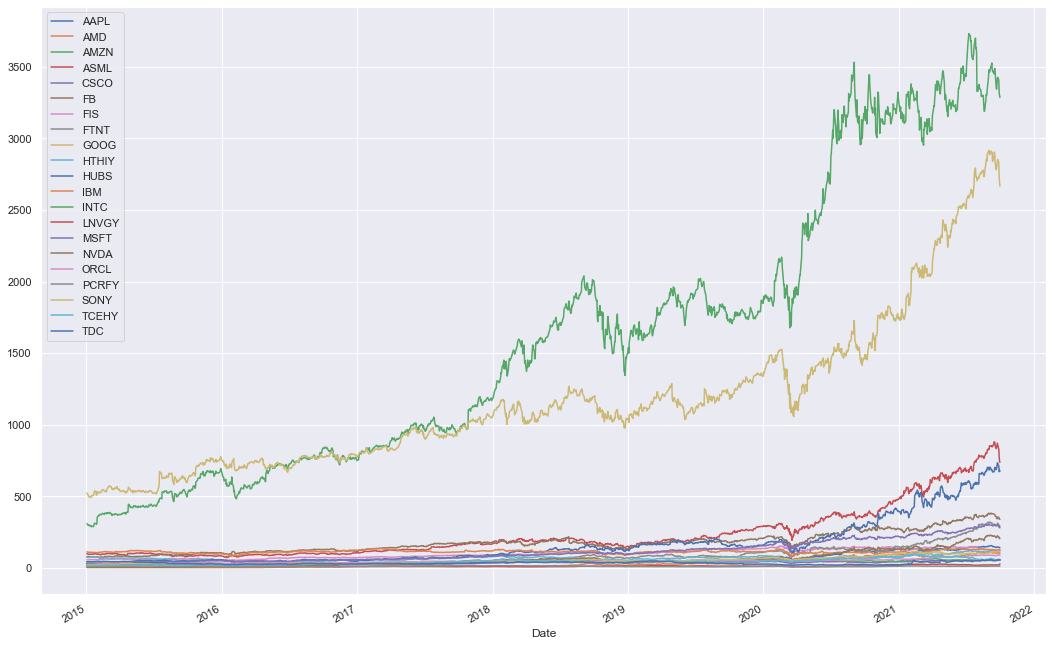

In [21]:
#extract out adjusted close prices
dfClose = dfData['Adj Close'].copy()

#plot the adjusted close prices
dfClose.plot(figsize=(18,12))
plt.show()

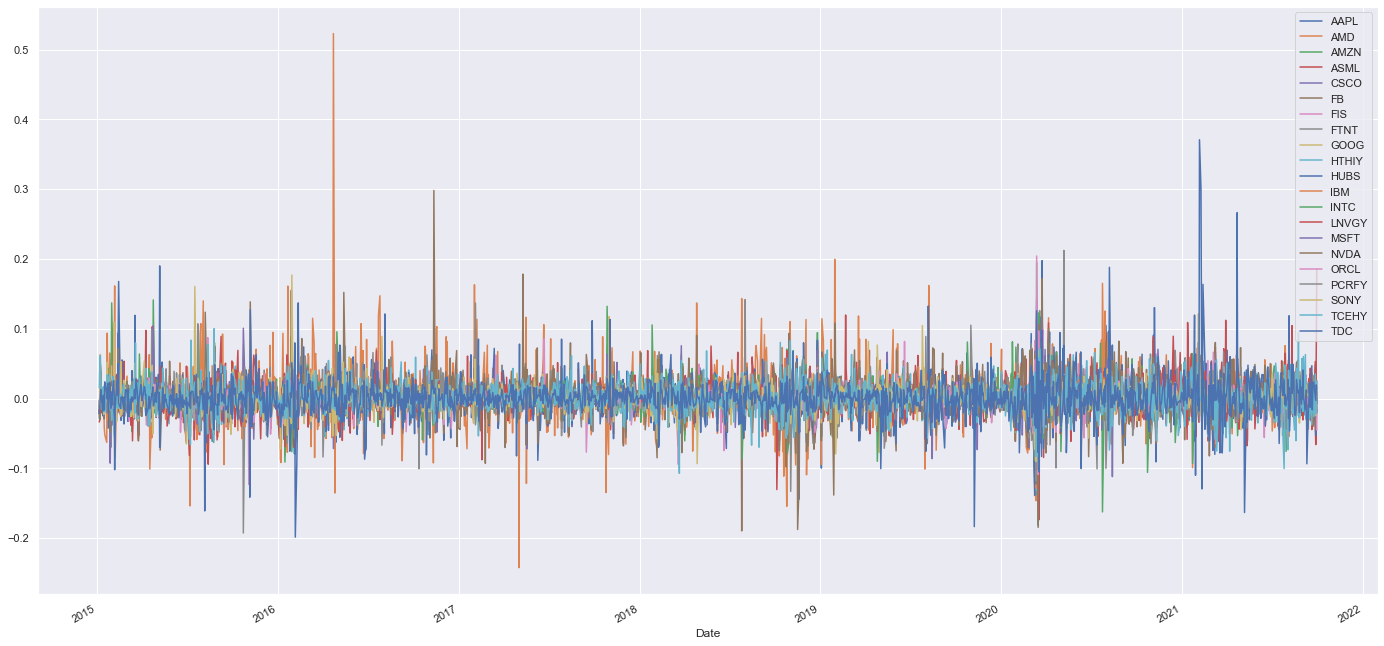

In [22]:
#compute differences in close prices
dfClose = dfClose.pct_change().dropna()

#plot the differenced close prices
dfClose.plot(figsize=(24,12))
plt.show()

In [23]:
#standardise data set
scaler = StandardScaler()
closes = scaler.fit_transform(dfClose)
dfClose = pd.DataFrame(closes,columns=dfClose.columns)


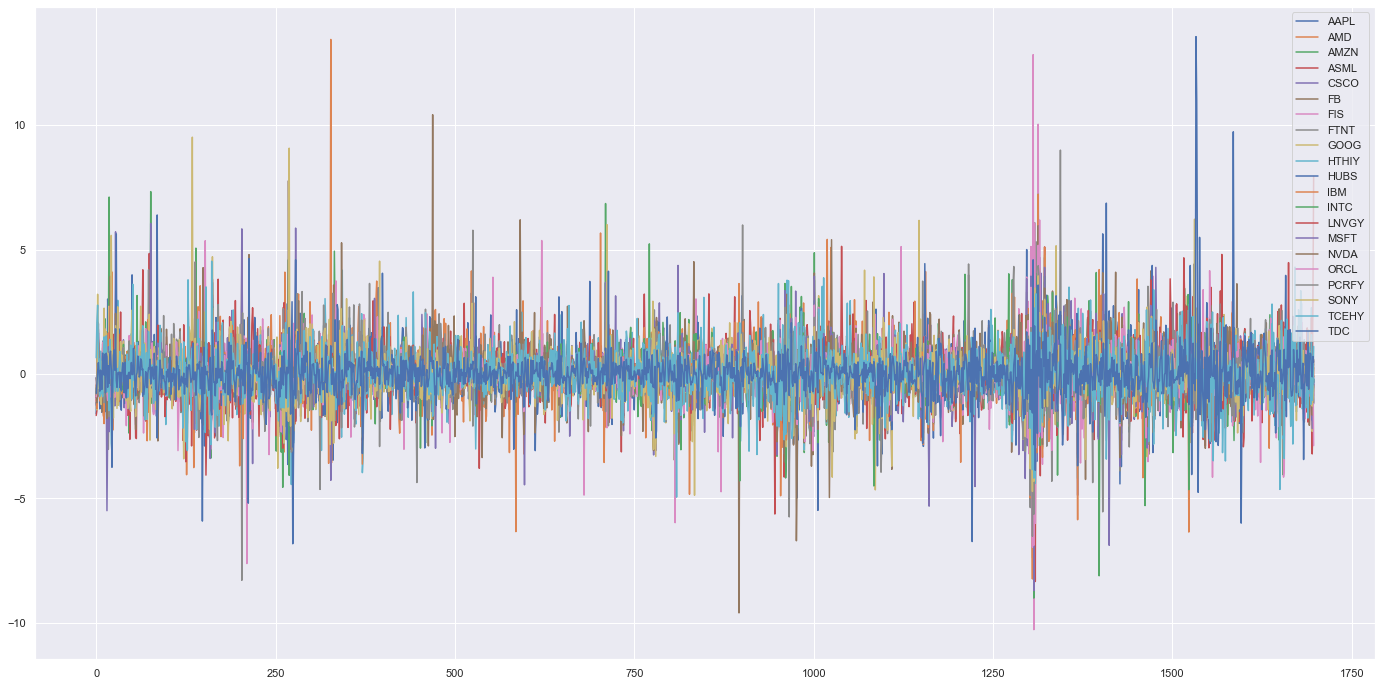

In [24]:
#plot the standardised close price differences
dfClose.plot(figsize=(24,12))
plt.show()

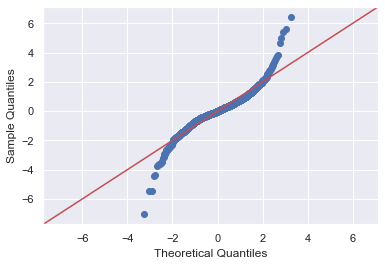

In [25]:
#create Q-Q plot with 45-degree line added to plot AAPL
fig = sm.qqplot(dfClose.AAPL.values, dist=stats.norm, loc=0, scale=1, line='45')
plt.show()

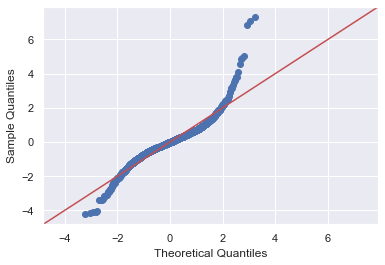

In [26]:
#create Q-Q plot with 45-degree line added to plot AMZN
fig = sm.qqplot(dfClose.AMZN.values, dist=stats.norm, loc=0, scale=1, line='45')
plt.show()

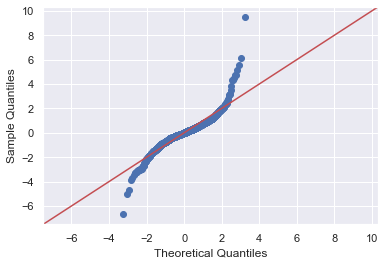

In [27]:
#create Q-Q plot with 45-degree line added to plot GOOG
fig = sm.qqplot(dfClose.GOOG.values, dist=stats.norm, loc=0, scale=1, line='45')
plt.show()


In [28]:
#class that encapsulates the PCA model
class PCA(object):
    #initialiser function
    def __init__(self,n_components : int = 0) -> None:
        self.n_components = n_components
        self.e_val        = np.array([])
        self.e_vec        = np.array([])
        self.col_idx      = np.array([])
        
    #destructor
    def __del__(self) -> None:
        del self.n_components
        del self.e_val
        del self.e_vec
        del self.col_idx
        
    #public function to train the model
    def fit(self, X_train : np.array) -> None:
        #since I'm assuming the input matrix X_train has shape (samples,features), compute the transpose
        X = np.transpose(X_train)
        #remove the mean from each feature
        X -= np.mean(X,axis=1).reshape(-1,1)
        #compute the covariance matrix of X
        C = np.matmul(X,np.transpose(X))
        #find the eigenvalues & eigenvectors of the covariance
        self.e_val,self.e_vec = np.linalg.eig(C)
        #sort the negated eigenvalues (to get sort in decending order)
        self.col_idx = np.argsort(-self.e_val)
    
    #public function to transform the dataset
    def transform(self, X) -> np.array:
        #check that the model has been trained?
        if self.e_val.size and self.e_vec.size and self.col_idx.size:
            #since I'm assuming the input matrix X_train has shape (samples,features), compute the transpose
            X = np.transpose(X)
            #project data onto the PCs
            X_new = np.matmul(np.transpose(self.e_vec),X)
            #transform back via tranpose + sort by variance explained
            X_new = np.transpose(X_new)
            X_new = X_new[:,self.col_idx]
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                X_new = X_new[:,:self.n_components]
            #return
            return(X_new)
        else:
            print('Empty eigenvectors and eigenvalues, did you forget to train the model?')
            return(np.array([]))

    #public function to return % explained variance per PC
    def explained_variance_ratio(self) -> np.array:
        #check that the model has been trained?
        if self.e_val.size and self.col_idx.size:
            #compute the sorted % explained variances 
            perc = self.e_val[self.col_idx]
            perc = perc/np.sum(perc)
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                perc = perc[:self.n_components]
            #return
            return(perc)
        else:
            print('Empty eigenvalues, did you forget to train the model?')
            return(np.array([]))

    #public function to return the eigenvalues & eigenvectors
    def return_eigen_vectors_values(self) -> Tuple[np.array,np.array]:
        #check that the model has been trained?
        if self.e_val.size and self.e_vec.size and self.col_idx.size:
            #sort the eigenvalues and eigenvectors
            e_val = self.e_val[self.col_idx]
            e_vec = self.e_vec[:,self.col_idx]
            #if n_components was specified, return only this number of features back
            if self.n_components != 0:
                e_val = e_val[:self.n_components]
                e_vec = e_vec[:,:self.n_components]
            #return
            return(e_vec,e_val)
        else:
            print('Empty eigenvalues & eigenvectors, did you forget to train the model?')
            return(np.array([]),np.array([]))        

In [29]:
#fit the PCA model and transform the data
pca_custom = PCA()
pca_custom.fit(closes)
pcs        = pca_custom.transform(closes)
dfPCs1     = pd.DataFrame(pcs,columns=['PC'+str(i) for i in range(1,dfClose.shape[1]+1)])

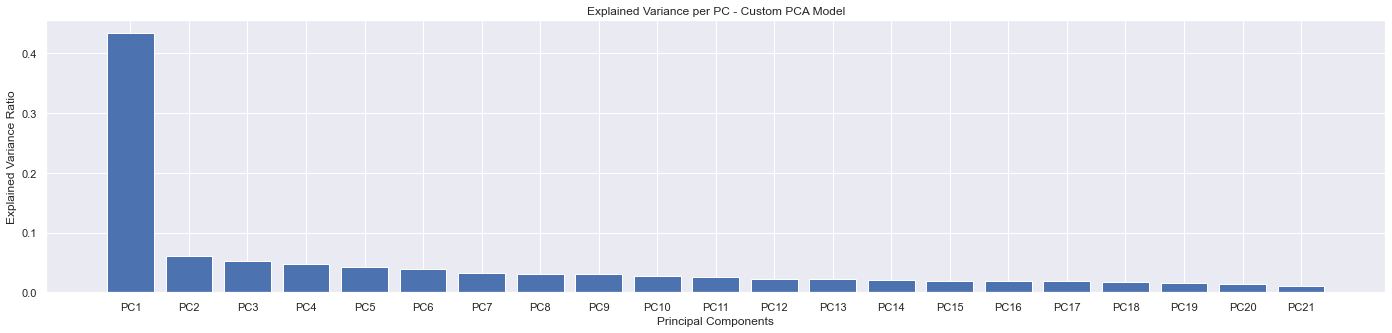

In [31]:
#how much variance is explained by each pc?
f, ax = plt.subplots(figsize=(24,5))
plt.bar(['PC'+str(i) for i in range(1,22)],pca_custom.explained_variance_ratio())
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance per PC - Custom PCA Model')
plt.show()

In [32]:
#import scikit-learn PCA
from sklearn.decomposition import PCA

#fit the PCA model and transform the data
pca    = PCA()
pcs    = pca.fit_transform(closes)
dfPCs2 = pd.DataFrame(pcs,columns=['PC'+str(i) for i in range(1,dfClose.shape[1]+1)])

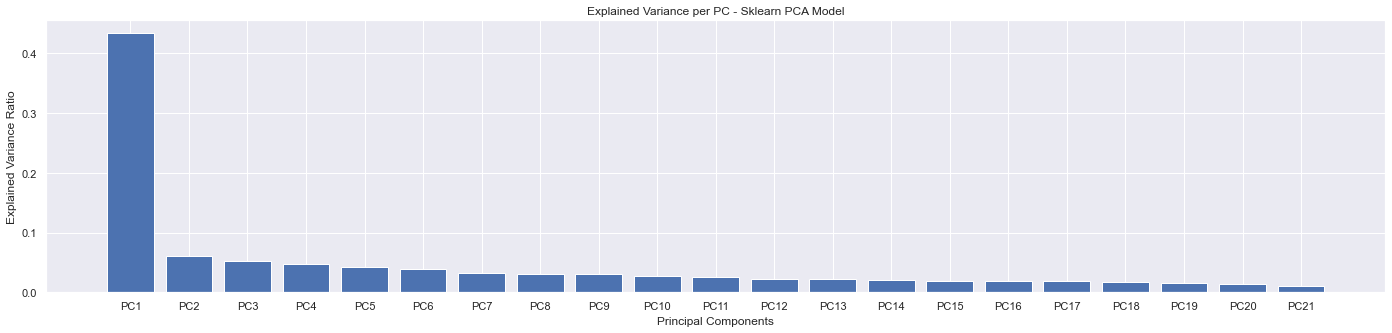

In [33]:
#how much variance is explained by each pc?
f, ax = plt.subplots(figsize=(24,5))
plt.bar(['PC'+str(i) for i in range(1,22)],pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.title('Explained Variance per PC - Sklearn PCA Model')
plt.show()

In [34]:
#check if our two outputs are equal?
np.allclose(dfPCs1,dfPCs2)

False

In [35]:
#... ok what if we just compare the absolute values?
np.allclose(np.absolute(dfPCs1),np.absolute(dfPCs2))

True

In [36]:
#extract out our eigenvectors from the trained model
dfLoadings = pd.DataFrame(pca.components_,columns=dfClose.columns,index=dfPCs2.columns)

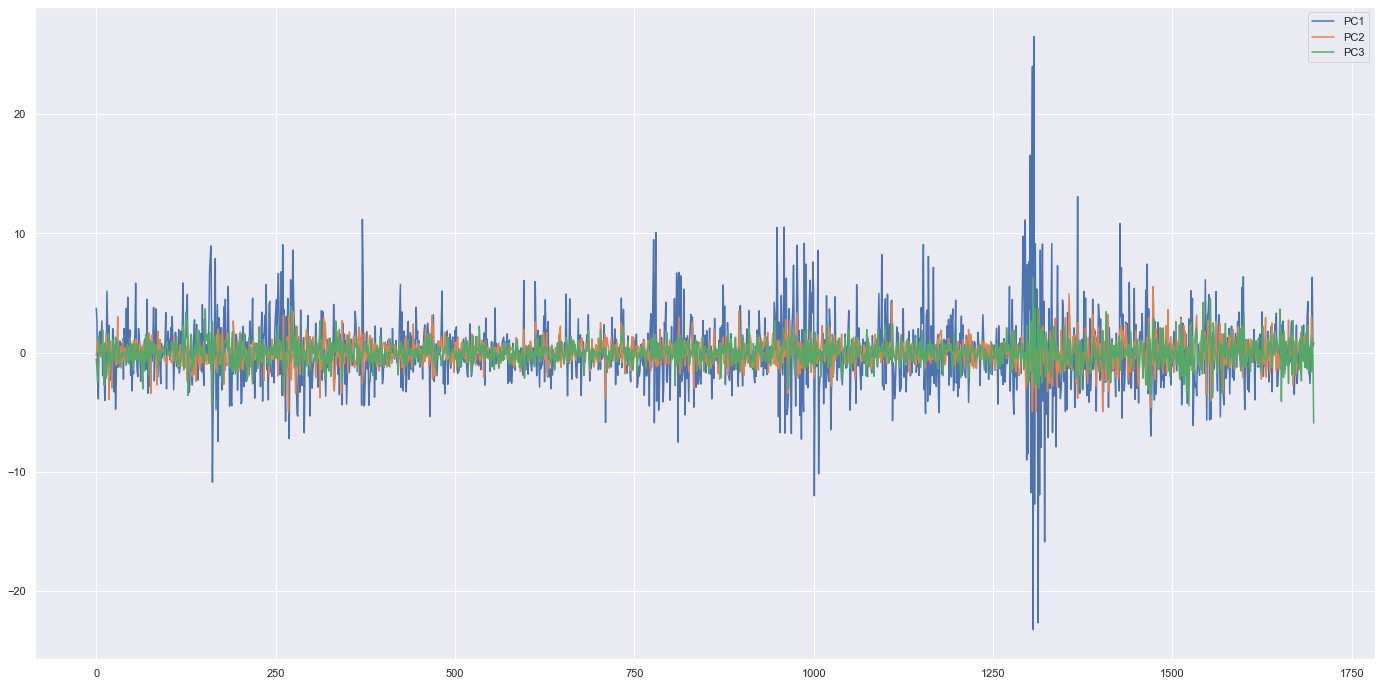

In [38]:
#plot just the first 3 PCs
dfPCs2[['PC1','PC2','PC3']].plot(figsize=(24,12))
plt.show()

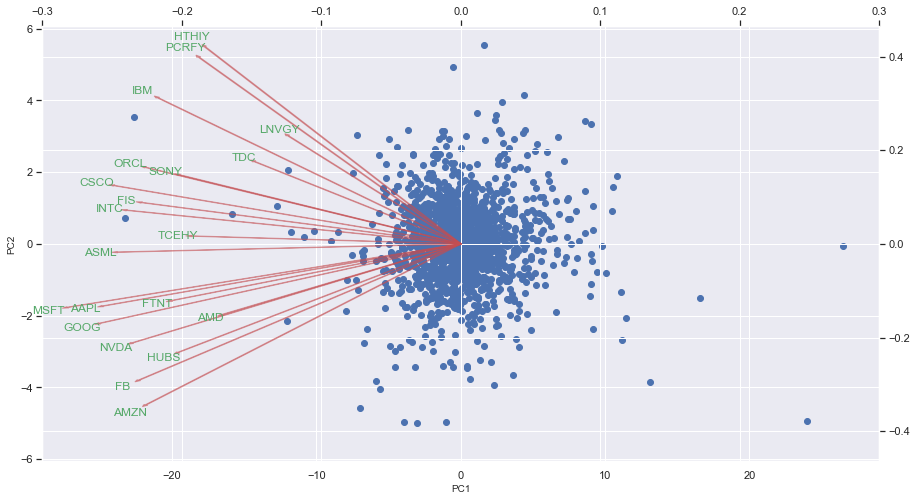

In [40]:
#produce biplot
biplot(dfPCs2, dfLoadings)

In [41]:
#isolate out just the first 2 principal components
dfPC12 = dfPCs2[['PC1','PC2']].copy()

In [42]:
#0.5% and 99.5% percentiles
pc1_q = np.percentile(dfPC12.PC1.values,q=[0.5,99.5])
pc1_q

array([-9.60784217, 10.51759798])

In [43]:
#0.5% and 99.5% percentiles
pc2_q = np.percentile(dfPC12.PC2.values,q=[0.5,99.5])
pc2_q

array([-3.79466067,  3.38275496])

In [44]:
#work out coordinates for PC1
u = np.mean(pc1_q)
a = pc1_q[1] - u

#work out coordinates for PC2
v = np.mean(pc2_q)
b = pc2_q[1] - v

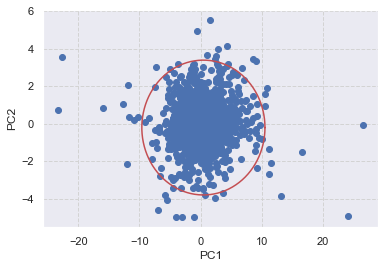

In [45]:
#draw 2D ellipse in PC space
t = np.linspace(0, 2*math.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) , color='r' )
plt.grid(color='lightgray',linestyle='--')
plt.scatter(dfPC12.PC1.values,dfPC12.PC2.values, color='b')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [46]:
#attach dates to the PC dataframe
dfPC12['Date'] = dfData.index.values[1:]

#attach boolean feature to flag outlier points 
dfPC12['Outlier'] = [outside_ellipse(x,y,u,v,a,b) for x,y in zip(dfPC12.PC1.values,dfPC12.PC2.values)]

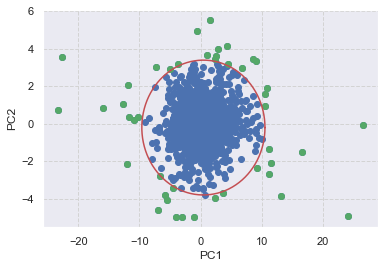

In [47]:
#isolate out the outliers
dfOutliers = dfPC12[dfPC12.Outlier].copy()
dfOutliers.reset_index(inplace=True,drop=True)

#draw 2D ellipse in PC space & show outliers
t = np.linspace(0, 2*math.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) , color='r' )
plt.grid(color='lightgray',linestyle='--')
plt.scatter(dfPC12.PC1.values,dfPC12.PC2.values, color='b')
plt.scatter(dfOutliers.PC1.values,dfOutliers.PC2.values, color='g')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

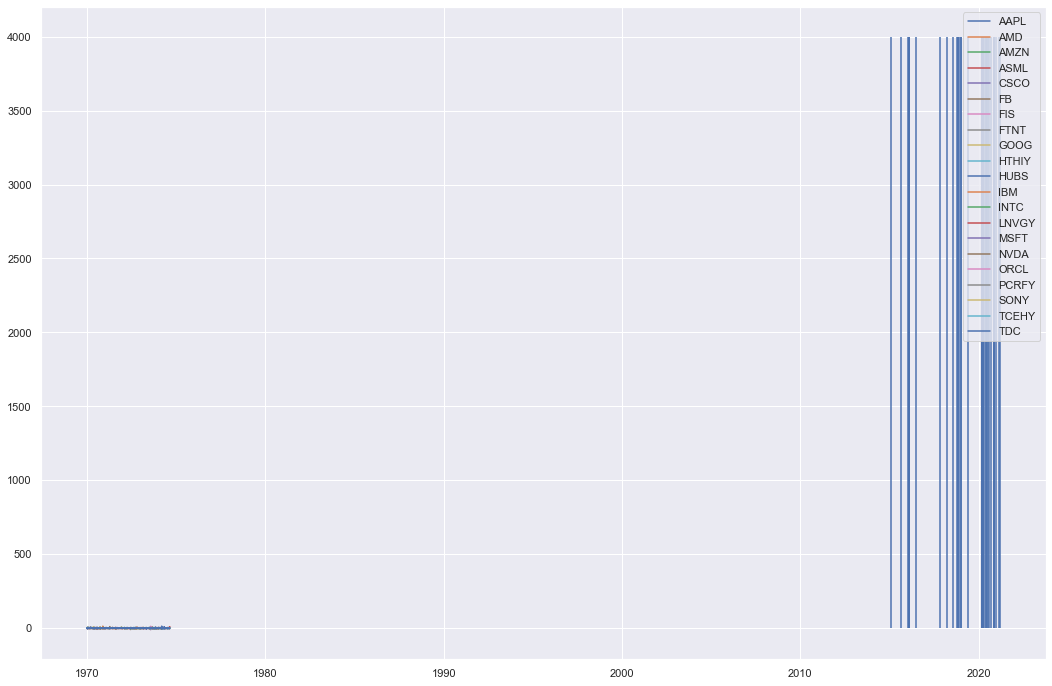

In [48]:
#visualise stock prices overlayed with outlier time points
dfClose.plot(figsize=(18,12))
plt.vlines(dfOutliers.Date,0,4000)
plt.show()

In [49]:
#read in data from yahoo
stocks = "AAPL MSFT AMZN FB GOOG NVDA FIS AMD TDC HUBS FTNT ASML INTC IBM ORCL CSCO " \
         "SONY HTHIY TCEHY PCRFY LNVGY"
dfData = yf.download(stocks, start="2021-10-02", end="2021-11-18")

[*********************100%***********************]  21 of 21 completed


In [50]:
#extract out adjusted close prices
dfClose = dfData['Adj Close'].copy()

#compute differences in close prices
dfClose = dfClose.pct_change().dropna()

#standardise the dataset with the scaler already fitted
closes = scaler.transform(dfClose)

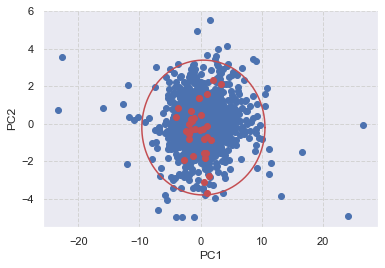

In [51]:
#transform data into PC space
pc = pca.transform(closes)

#draw 2D ellipse in PC space & show predictions
t = np.linspace(0, 2*math.pi, 100)
plt.plot( u+a*np.cos(t) , v+b*np.sin(t) , color='r' )
plt.grid(color='lightgray',linestyle='--')
plt.scatter(dfPC12.PC1.values,dfPC12.PC2.values, color='b')
plt.scatter(pc[:,0],pc[:,1], color='r')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [52]:
#compute index
idx = int(np.where(pc[:,1] == np.amin(pc[:,1]))[0])
idx

12

In [53]:
#what date corresponds to our maximum?
dfClose.iloc[idx].name

Timestamp('2021-10-21 00:00:00')

In [54]:
#do element-wise multiplication
products = np.multiply(dfLoadings.loc[['PC1','PC2'],:].values,closes[idx,:])

#package up the components into a dataframe
dfProducts = pd.DataFrame(np.abs(products),columns=dfLoadings.columns,index=['PC1','PC2'])

#sort by value on PC1
dfProducts.sort_values(by=['PC1'], axis=1, ascending=False)

,IBM,ASML,HTHIY,PCRFY,NVDA,MSFT,CSCO,INTC,AMD,ORCL,...,LNVGY,AMZN,HUBS,TCEHY,SONY,FIS,FB,GOOG,FTNT,AAPL
PC1,1.333509,0.287248,0.274869,0.214616,0.199637,0.158829,0.148042,0.129280,0.098930,0.058434,...,0.050841,0.050555,0.046246,0.046106,0.029850,0.029667,0.025206,0.022685,0.009466,0.003882
PC2,1.915642,0.020677,0.630572,0.455542,0.179268,0.076367,0.074174,0.038738,0.087357,0.042247,...,0.094833,0.076973,0.052897,0.003991,0.021806,0.011445,0.031785,0.014865,0.005533,0.002008


In [55]:
#sort by value on PC2
dfProducts.sort_values(by=['PC2'], axis=1, ascending=False)

,IBM,HTHIY,PCRFY,NVDA,LNVGY,AMD,AMZN,MSFT,CSCO,TDC,...,ORCL,INTC,FB,SONY,ASML,GOOG,FIS,FTNT,TCEHY,AAPL
PC1,1.333509,0.274869,0.214616,0.199637,0.050841,0.098930,0.050555,0.158829,0.148042,0.057935,...,0.058434,0.129280,0.025206,0.029850,0.287248,0.022685,0.029667,0.009466,0.046106,0.003882
PC2,1.915642,0.630572,0.455542,0.179268,0.094833,0.087357,0.076973,0.076367,0.074174,0.068858,...,0.042247,0.038738,0.031785,0.021806,0.020677,0.014865,0.011445,0.005533,0.003991,0.002008


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

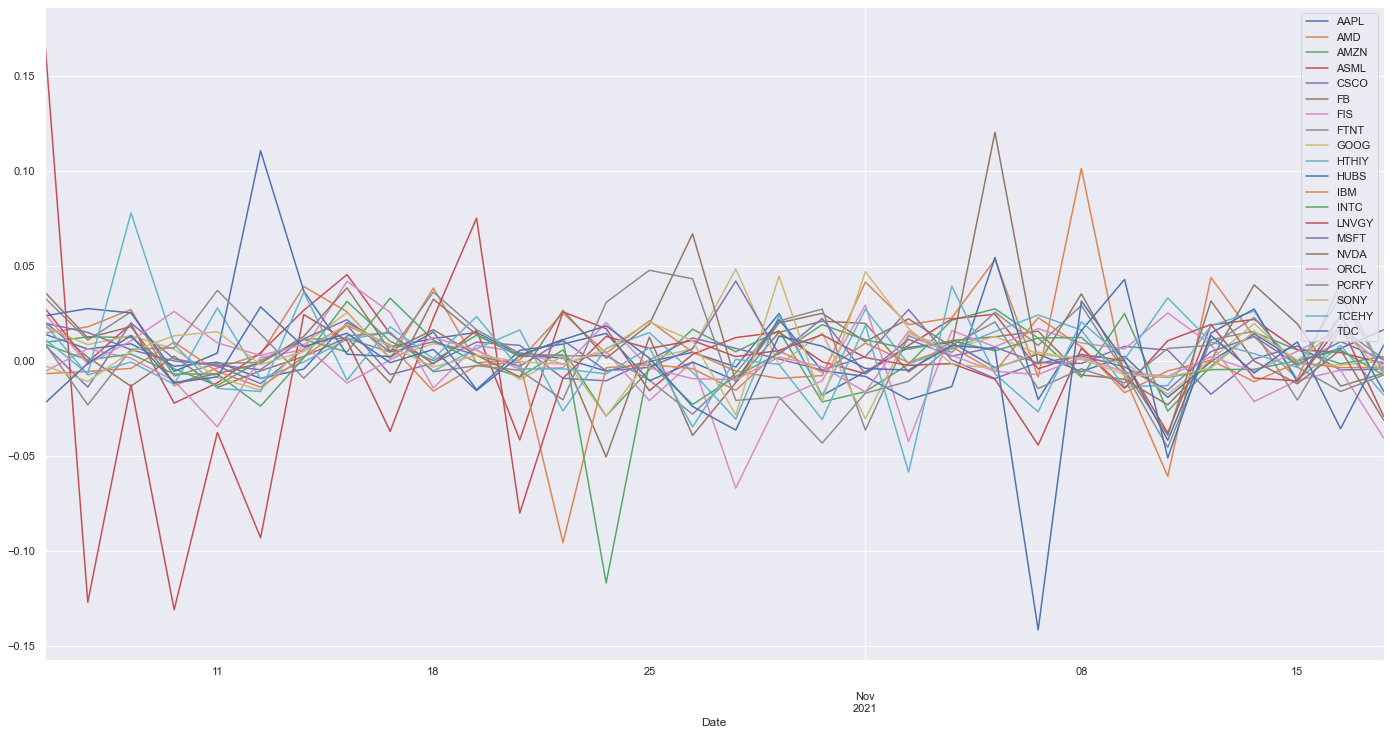